In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import xarray as xr
import cartopy.crs as ccrs
from scipy.signal import detrend
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# some settings for plotting and printing
#plt.rcParams['figure.figsize'] = (9, 5)
#plt.rcParams['font.size'] = 18
#np.set_printoptions(precision=4, suppress=True)

In [7]:
# uncomment if you haven't done that step yet 
#!wget https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/sst/data.nc .
#!mv data.nc data_orig.nc
!ncatted -O -a calendar,T,o,c,"360_day" data_orig.nc sst.nc

In [9]:
# load SST file into data sets 
ds_sst = xr.open_dataset("sst.nc").squeeze("zlev").drop("zlev")

# we give the dimensions a standard name, e.g., "T" -> "time", etc.
new_dims = {'T': 'time', 'Y': 'latitude', 'X': 'longitude'}
ds_sst = ds_sst.rename(new_dims).set_coords(['longitude', 'latitude', 'time'])

# select a time period using ".sel()"
# and "slice" the time for the period between 1950 and 2022
ds_sst = ds_sst.sel(time=slice("1949-09","2022"))

In [10]:
# define a function that subtracts the mean along the "time" dimension
def subtract(x):
    return x - x.mean(dim="time")

# define our custom detrend function that also fills NaNs with 0s
def detrend_(x):
    return detrend(x.fillna(0),axis=0)

In [11]:
# we'll keep a copy after each step as reference ("ds0","ds1","ds2")
# but override "ds_sst"
ds0 = ds_sst*1.0

# apply the detrending
ds_sst = ds_sst.map(detrend_)
ds1 = ds_sst*1.0

# apply the subtraction of the monthly means, using "groupby"
ds_sst = ds_sst.groupby("time.month").map(subtract)
ds2 = ds_sst*1.0

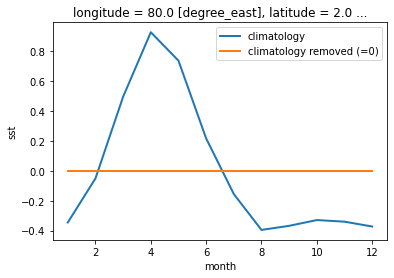

In [12]:
# plot the climatological monthly means as time series for a location (80E, 2N)
ds1["sst"].groupby("time.month").mean() \
    .sel(longitude=80,latitude=2).plot(label="climatology",lw=2)
ds2["sst"].groupby("time.month").mean() \
    .sel(longitude=80,latitude=2).plot(label="climatology removed (=0)",lw=2)
plt.legend();

In [13]:
# define Nino3.4 region boundaries
lon1 = 360-170; lon2 = 360-120
lat1 = -5; lat2 = 5
# also the other NINO regions
# Nino1.2
lon1_12 = 360-90; lon2_12 = 360-80
lat1_12 = -10; lat2_12 = 0
# Nino3
lon1_3 = 360-150; lon2_3 = 360-90
lat1_3 = -5; lat2_3 = 5
# Nino4
lon1_4 = 160; lon2_4 = 360-150
lat1_4 = -5; lat2_4 = 5

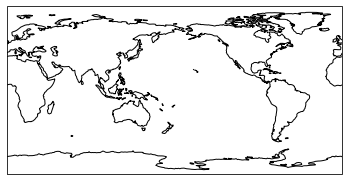

In [14]:
# define projection of SST data: lonlat grid -> "PlateCarree()"
data_proj = ccrs.PlateCarree()
# define projection for maps
proj = ccrs.PlateCarree(central_longitude=180)

# create figure and axis with map projection
fig, ax = plt.subplots(1,1,subplot_kw={'projection':proj})
# draw some coastlines
ax.coastlines();

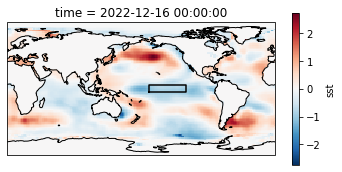

In [15]:
# plot SST anomalies for last month,
# i.e, the last time index, -1
ds_sst["sst"][-1].plot(ax=ax,transform=data_proj,cbar_kwargs={"shrink": 0.7})
# plot extend of Nino3.4
nino34 = [lon1,lon2,lon2,lon1,lon1],[lat1,lat1,lat2,lat2,lat1]
ax.plot(*nino34,'k-',transform=data_proj)
fig

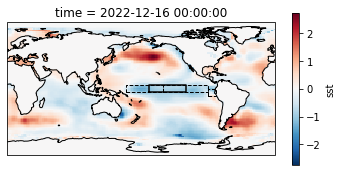

In [16]:
# add other Nino region outlines 
nino12 = [lon1_12,lon2_12,lon2_12,lon1_12,lon1_12],[lat1_12,lat1_12,lat2_12,lat2_12,lat1_12]
ax.plot(*nino12,'k--',lw=1,transform=data_proj)
nino3 = [lon1_3,lon2_3,lon2_3,lon1_3,lon1_3],[lat1_3,lat1_3,lat2_3,lat2_3,lat1_3]
ax.plot(*nino3,'k--',lw=1,transform=data_proj)
nino4 = [lon1_4,lon2_4,lon2_4,lon1_4,lon1_4],[lat1_4,lat1_4,lat2_4,lat2_4,lat1_4]
ax.plot(*nino4,'k--',lw=1,transform=data_proj);
fig

In [17]:
# slice dataset along Nino3.4 boundaries
# i.e., between "lon1" and "lon2",
# and between "lat1" and "lat2"
sst = ds_sst["sst"].loc[{
    'latitude': slice(lat1,lat2),
    'longitude': slice(lon1,lon2)
}]


In [18]:
sst

<xarray.DataArray 'sst' (time: 880, latitude: 5, longitude: 26)>
array([[[-0.0201,  0.0275,  0.0755, ..., -0.5946, -0.6307, -0.7058],
        [-0.1577, -0.105 , -0.0707, ..., -0.726 , -0.7683, -0.8429],
        [-0.2815, -0.2302, -0.2051, ..., -0.8082, -0.8599, -0.9185],
        [-0.3989, -0.3745, -0.3852, ..., -0.8084, -0.859 , -0.925 ],
        [-0.526 , -0.5181, -0.5725, ..., -0.7056, -0.7759, -0.7711]],

       [[-0.3028, -0.1723, -0.0654, ..., -0.9697, -1.0185, -1.1024],
        [-0.5145, -0.3525, -0.2461, ..., -1.3143, -1.3728, -1.4545],
        [-0.694 , -0.5154, -0.4094, ..., -1.4925, -1.5628, -1.6265],
        [-0.83  , -0.6794, -0.6066, ..., -1.4035, -1.4691, -1.534 ],
        [-0.9241, -0.8107, -0.7835, ..., -1.0929, -1.1733, -1.1596]],

       [[-0.42  , -0.373 , -0.3313, ..., -1.3818, -1.4036, -1.4513],
        [-0.6696, -0.6074, -0.5683, ..., -1.8798, -1.9043, -1.943 ],
        [-0.8198, -0.7508, -0.7179, ..., -2.1163, -2.1382, -2.1496],
        [-0.8489, -0.8043, -0.8072, ..., -1.9376, -1.9392, -1.9488],
        [-0.7765, -0.7505, -0.7934, ..., -1.4652, -1.4733, -1.4073]],

       ...,

       [[-1.3285, -1.2741, -1.2265, ..., -1.0417, -1.0807, -1.1307],
        [-1.3856, -1.2892, -1.223 , ..., -1.1108, -1.1545, -1.2069],
        [-1.3598, -1.2418, -1.1593, ..., -1.0706, -1.1273, -1.1815],
        [-1.2265, -1.1184, -1.0334, ..., -0.9814, -1.0373, -1.0826],
        [-1.0062, -0.9265, -0.8523, ..., -0.8601, -0.9151, -0.9521]],

       [[-1.2006, -1.1312, -1.0712, ..., -0.9819, -0.9991, -1.0318],
        [-1.2521, -1.1359, -1.0547, ..., -1.0233, -1.0325, -1.0566],
        [-1.2459, -1.1046, -1.0069, ..., -0.9602, -0.9706, -0.9844],
        [-1.141 , -1.0129, -0.9176, ..., -0.864 , -0.8633, -0.8591],
        [-0.9516, -0.8628, -0.7874, ..., -0.7403, -0.7378, -0.7257]],

       [[-1.1058, -1.0578, -1.0104, ..., -1.007 , -1.0102, -1.0242],
        [-1.194 , -1.1126, -1.0471, ..., -1.0188, -1.016 , -1.0241],
        [-1.2127, -1.1187, -1.0422, ..., -0.9592, -0.9636, -0.9674],
        [-1.1141, -1.0387, -0.9706, ..., -0.8747, -0.8731, -0.8672],
        [-0.918 , -0.8743, -0.8291, ..., -0.7612, -0.7622, -0.7564]]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 190.0 192.0 194.0 196.0 ... 236.0 238.0 240.0
  * time       (time) object 1949-09-16 00:00:00 ... 2022-12-16 00:00:00
  * latitude   (latitude) float32 -4.0 -2.0 0.0 2.0 4.0